# Figure 1

H. Sanchez & F. Palmero @ Nynke Dekker Lab \
2022/11/05

In [11]:
# Imports
import os
import yaml
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.proportion
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

## Parameters & Directories

In [12]:
# Directory for figures data
data_dir = r'figure_data/Figure 1/'

# Directory for raw data
data_path = os.path.join(data_dir, "scans_example.csv")

In [13]:
# DNA information
dna_length = 10.439         # kbp
origin = 6.896              # kbp location of the origin of replication
NPS1 = 6.750                # kbp location of the first nucleosome position sequence
NPS2 = 7.04                 # kbp location of the second nucleosome position sequence
locs_from_center = [ dna_length/2 - origin]  # Locations from center in kbp.

# Location bins; origin should be in third bin
binwidth = (origin - dna_length/2) / 2.5

## Raw data

In [14]:
df_scans = pd.read_csv(data_path)
df_scans.head()

Unnamed: 0.1  Unnamed: 0  frame  intensity  frame_subindex  track_id  \
0             0           0      0       86.0               0         0   
1             1           1      1      120.0               0         0   
2             2           2      2      109.0               0         0   
3             3           3      3      134.0               0         0   
4             4           4      4      124.0               0         0   

   scan_id  dna_start_pixel  dna_end_pixel  n_scans  ...  col_dist  trace_id  \
0        0        14.821568      76.983004      429  ...       NaN         0   
1        0        14.821568      76.983004      429  ...       NaN         0   
2        0        14.821568      76.983004      429  ...       NaN         0   
3        0        14.821568      76.983004      429  ...       NaN         0   
4        0        14.821568      76.983004      429  ...       NaN         0   

   corrected_intensity  dna_length_kbp  laser_colors time_s     x_kbp  \
0                 86.0          10.439            rb    0.0  7.045213   
1                120.0          10.439            rb    0.6  6.956408   
2                109.0          10.439            rb    1.2  6.884567   
3                134.0          10.439            rb    1.8  6.946025   
4                124.0          10.439            rb    2.4  7.054975   

   x_micron  step_count  lifetime  
0  2.030494         3.0      37.0  
1  2.004899         3.0      37.0  
2  1.984194         3.0      37.0  
3  2.001907         3.0      37.0  
4  2.033307         3.0      37.0  

[5 rows x 28 columns]

## Functions

In [15]:
def plot_location_histogram(NN, fig, ax, bandw, cut_v, lw, color_s, binwidth,
                            data, color='gray', edgecolor='k', ylim=0.3, filename=None, vlines=[]):
    """Generate location histogram figure."""

    # Config axis
    ax2 = ax.twinx()
    ax.set_ylim((0, 1.1))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])

    ax2.set_ylim(0, ax.get_ylim()[1] / binwidth)
    ax2.set_yticks([0.0, 0.5, 1, 1.5])
    ax2.axvline(x=locs_from_center, color='k', linestyle='--', zorder=100)

    ax2.set_ylabel(f'PDF (1/kbp)', color='#de59d7', rotation=270, labelpad=22,
                       path_effects=[pe.withStroke(linewidth=2, foreground='black', capstyle="round")])

    ax.set_ylabel('Fraction')
    ax.set_xlabel("kbp from DNA center")

    plt.xlim((0, binwidth*len(data['bins'])))
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.xlabel('kbp from DNA center')

    # Plot histogram.
    ax.bar(data['bins'], data['values'], align='center', width=data['bin_width'], color=color, edgecolor=edgecolor)

    plt.annotate("$N_{scans}$ = " + str(NN), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
    plt.annotate("$N_{foci}$ = " + str(len(data['locs_all'])), xy=(0.99, 0.85),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    for x in vlines:
        plt.axvline(x, linestyle='dashed', color='k')

    # Include density plot
    sns.kdeplot(data['locs_all'], bw_method=bandw, cut=cut_v, linewidth= 2,
                    color='#de59d7', path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],
                     ax=ax2, zorder=99);

    # Cleanup.
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    return fig

def plot_stoichiometry(NN, data, fig, ax, colors=None, edgecolor=None, filename=None, method='wilson',
                       significance=0.3173):
    """Generate stoichiometry figure."""

    # Config axis
    if not data['norm_per_scan']:
        plt.ylabel('Fraction')
    else:
        plt.ylabel('count per scan')

    # Plot bar
    if colors is None:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color='gray')
    else:
        ax.bar(data['x'], data['freqs'], align='center', width=0.8, color=colors, edgecolor=edgecolor)

    # Cleanup.
    ax.xaxis.set_major_locator(plt.FixedLocator(data['x']))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(data['names']))
    plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    plt.ylim(0, 0.9)
    plt.annotate("$N_{foci}$ = " + str(data['n_traces']), xy=(0.99, 0.98),
                 xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    # Add standard error of the proportion
    n_obs = data['n_traces']
    errs = []
    for b, c in zip(data['x'], data['freqs']):
        if c == 0:
            err = [0, 0]
        else:
            err = list(statsmodels.stats.proportion.proportion_confint(c * n_obs, n_obs,
                                                                       alpha=significance, method=method))
            err[0] = c - err[0]
            err[1] = err[1] - c
        errs.append(err)
    errs = np.array(errs).swapaxes(0, 1)

    plt.errorbar(data['x'], data['freqs'], errs, fmt=' ', color='k', capsize=5, elinewidth=1, markeredgewidth=1)

    fig.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

    return fig, ax

def plot_lifetime(data,  color, ax):
    """Plot the lifetime data generated with get_lifetime()."""

    ax.plot(data['xvals'], data['yvals'], 'o', color='k')
    ax.plot(data['xvals'], data['yfit'], color=color, linewidth= 5)
    ax.annotate("$N_{dyes}$ = " + str(data['count']), xy=(0.99, 0.98),
                xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')
    ax.annotate("τ= %.2f " % data['mean_lifetime'] + data['t_unit']
                + " ± %.2f " % data['std'] + data['t_unit'], xy=(0.99, 0.85),
                xycoords='axes fraction', horizontalalignment='right', verticalalignment='top')

    return fig, ax

In [16]:
def get_visible_h2a(p_h2a, p_l, p_occ):
    """Calculate number of visible h2a from association probability and labeling efficiency."""
    
    # Calculate chances of site occupation.
    p_occ0 = (1 - p_occ) ** 2
    p_occ1 = 2 * p_occ * (1 - p_occ)
    p_occ2 = p_occ ** 2
    
    # Calculate chances of tetrasome, hexasome, full nucleosome, if site is occupied.
    p_tet = (1 - p_h2a) ** 2
    p_hex = 2 * p_h2a * (1 - p_h2a)
    p_nuc = p_h2a ** 2
    
    # Calculate the probability distribution for the number of h2a (n) at the double NPS sites.
    # Not necessary to calculate p_n0
    p_n1 = p_occ1 * p_hex + \
           p_occ2 * 2 * p_tet * p_hex
    p_n2 = p_occ1 * p_nuc + \
           p_occ2 * (p_hex ** 2 + 2 * p_tet * p_nuc)
    p_n3 = p_occ2 * 2 * p_hex * p_nuc
    p_n4 = p_occ2 * p_nuc ** 2
    
    # Calculate the probability distribution for the number of visible  h2a (m).
    # Not necessary to calculate p_m0
    p_m1 = p_n1 * p_l + \
           p_n2 * 2 * p_l * (1 - p_l) + \
           p_n3 * 3 * p_l * (1 - p_l) ** 2 + \
           p_n4 * 4 * p_l * (1 - p_l) ** 3
    p_m2 = p_n2 * p_l ** 2 + \
           p_n3 * 3 * p_l ** 2 * (1 - p_l) + \
           p_n4 * 6 * p_l ** 2 * (1 - p_l) ** 2
    p_m3 = p_n3 * p_l ** 3 + \
           p_n4 * 4 * p_l ** 3 * (1 - p_l)
    p_m4 = p_n4 * p_l ** 4
    
    # Return normalized visible probabilities.
    p_array_visible = np.array([p_m1, p_m2, p_m3, p_m4])
    return p_array_visible / np.sum(p_array_visible)

## Plots

Optimal solution, only varying p_h2a: p_h2a = 0.9342549673367664
Resulting in stoichiometries [0.1991976  0.38502563 0.23388012 0.18189665]
MSE: 0.007236654452608632 

Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] = [0.76541754 1.        ]
Resulting in stoichiometries [0.13899116 0.34014554 0.36996435 0.15089896]
MSE: 5.182430577910179e-05


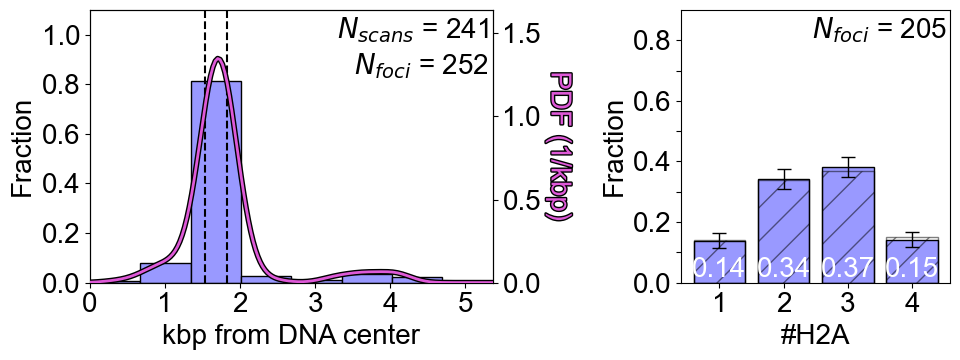

In [17]:
# Config style
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set the number of molecules
NN = len(df_scans['file_name'].unique())

# Generate figure
fig = plt.figure(constrained_layout=True,figsize=(10, 4))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.5,1])

###############################
# Plot localization histogram #
###############################

# Create axis
ax1 = fig.add_subplot(gs[0])

# Read data to plot
with open(os.path.join(data_dir, "datar00bl.yaml"), "r") as file:
       datar00bl = yaml.safe_load(file)

# Set plot parameters
bandw= binwidth/2
cut_v= 6
lw= 2
color_s= 'k'

# Plot histogram
plot_location_histogram(NN, fig, ax1, bandw, cut_v, lw, color_s, binwidth, datar00bl, '#9999ff' , edgecolor='k',
        ylim=0.8, vlines=[abs (dna_length/2 - NPS1), 
                        abs (dna_length/2 - NPS2)])

##################################
# Plot stoichiometries at origin #
##################################

# Create axis
ax3 = fig.add_subplot(gs[1])

# Read data to plot
with open(os.path.join(data_dir, "datab0ori.yaml"), "r") as file:
       datab0ori = yaml.safe_load(file)
plot_stoichiometry(NN, datab0ori, fig, ax3, '#9999ff', edgecolor='k')

# Save data to do statisctics with stoichiometry
# raw_countsrbST = np.array(datab0ori['total_spots'], dtype='int')
# np.save(os.path.join(data_dir, r'analysis_results/03stoichiometry_orirST5.npy'), raw_countsrbST)


#################
# Probabilities #
#################

p_label = 0.81                            # Labeling efficiency.
p_occupancy = 0.7                         # Single site occupation probability.(from n_jumps)
p_data = np.array(datab0ori['freqs'])     # Real data

p_data = p_data / np.sum(p_data)          # Make sure p_data is normalized.

def mse_h2a_scalar(p_h2a, p_l=p_label, p_occ=p_occupancy, p_experiment=p_data):
    """Calculate the MSE with scalar input."""

    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)

def mse_h2a_tuple(p_tuple, p_l=p_label, p_experiment=p_data):
    """Calculate the MSE with p_h2a and p_occ as a tuple/array input."""
    p_h2a, p_occ = p_tuple
    p_predict = get_visible_h2a(p_h2a, p_l, p_occ)
    return np.mean((p_predict - p_experiment)**2)

# 1. Varying only p_h2a.
res = scipy.optimize.minimize_scalar(mse_h2a_scalar)
print('Optimal solution, only varying p_h2a: p_h2a =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x, p_label, p_occupancy))
print('MSE:', res.fun, '\n')

# Prepare for parameter declarations.
overview_model = {'data_dir': data_dir,
                  'Optimal solution, only varying p_h2a: p_h2a =' : res.x,
                  'MSE_only varying p_h2a' : res.fun}

# 2. Varying both probabilities.
res = scipy.optimize.minimize(mse_h2a_tuple, x0=[res.x, p_occupancy], bounds=[(0., 1.), (0., 1.)])
print('Optimal solution, varying p_h2a and p_occupancy: [p_h2a, p_occupancy] =', res.x)
print('Resulting in stoichiometries', get_visible_h2a(res.x[0], p_label, res.x[1]))
print('MSE:', res.fun)

overview_model ['Optimal solution, varying p_h2a and p_occupancy: p_h2a ='] = res.x
overview_model ['MSE_ varying p_h2a and p_occupancy'] = res.fun

# Save overview model
with open(os.path.join(data_dir, 'overview_model.yaml'), 'w') as file:
           documents = yaml.dump(overview_model, file)                                    
overview_model

############
# Plot bar #
############

# Compute height
height = get_visible_h2a(res.x[0], p_label, res.x[1])

# Plot bar
ax3.bar(datab0ori['x'], height, alpha=0.5,  fill=False, edgecolor='black', hatch="/")
for xval, fval in zip(datab0ori['x'], height):
    ax3.text(xval, 0.02, "%.2f" % fval, horizontalalignment='center', color = 'white')

ax3.set_xlabel("#H2A")
ax3.set_yticklabels(('0.0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8'))
ax3.set_xticklabels(('1','2','3','4'))

plt.show()

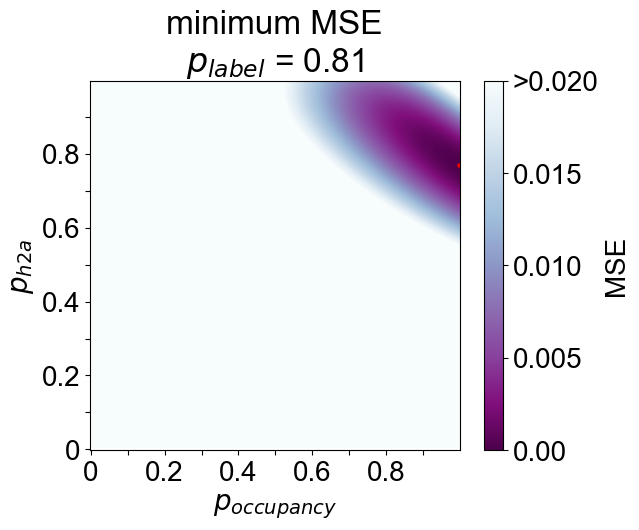

In [18]:
#################
# MSE landscape #
#################

# Config style
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Set parameters
n_pixels = 256
p_map = np.zeros((n_pixels, n_pixels))
p_min = np.zeros((n_pixels, n_pixels, 4))

# Compute p_h2a and p_occupancy
for x in range(n_pixels):
    for y in range(n_pixels):
        p_h2a = x / n_pixels
        p_o = y / n_pixels
        z = mse_h2a_scalar(p_h2a, p_label, p_o)
        p_map[x, y] = z

# Set scale
mse_min = np.amin(p_map[~np.isnan(p_map)].flatten())
x_min = np.nan
y_min = np.nan
for x in range(n_pixels):
    for y in range(n_pixels):
        if p_map[x, y] < mse_min * 1.001:
            p_min[x, y] = (1, 0, 0, 1)
            if not np.isnan(x_min):
                print('Warning: x_min, y_min already set...')
                print(f'Changed it from {x_min}, {y_min} to {x}, {y}')
            x_min = x
            y_min = y
        else:
            p_min[x, y] = (0, 0, 0, 0)

# Generate figure
plt.figure()

# Customize figure
plt.xlabel('$p_{occupancy}$')
plt.ylabel('$p_{h2a}$')
plt.title('minimum MSE\n$p_{label}$ = %.2f' % p_label)
plt.yticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))
plt.xticks(np.arange(0, n_pixels+1, n_pixels/10), ('0', ' ','0.2',' ','0.4',' ','0.6',' ', '0.8',' ', '1' ))

# Plot landscape
plt.imshow(p_map, origin='lower', cmap='BuPu_r', vmin=0, vmax=0.02)
cbar = plt.colorbar(label='MSE', ticks=[0., 0.005, 0.01, 0.015, 0.02])
cbar.ax.set_yticklabels(['0.00', '0.005', '0.010', '0.015', '>0.020'])
plt.scatter([y_min], [x_min], c='r', s=5)

plt.show()
plt.close()

In [19]:
# Load raw data
df_all = pd.read_csv(os.path.join(data_dir, "Bl0all.csv"))
df_all.head()

Unnamed: 0.1  Unnamed: 0  frame  intensity  frame_subindex  track_id  \
0             0           0      0       86.0               0         0   
1             1           1      1      120.0               0         0   
2             2           2      2      109.0               0         0   
3             3           3      3      134.0               0         0   
4             4           4      4      124.0               0         0   

   scan_id  dna_start_pixel  dna_end_pixel  n_scans  ...  col_dist  trace_id  \
0        0        14.821568      76.983004      429  ...       NaN         0   
1        0        14.821568      76.983004      429  ...       NaN         0   
2        0        14.821568      76.983004      429  ...       NaN         0   
3        0        14.821568      76.983004      429  ...       NaN         0   
4        0        14.821568      76.983004      429  ...       NaN         0   

   corrected_intensity  dna_length_kbp  laser_colors time_s     x_kbp  \
0                 86.0          10.439            rb    0.0  7.045213   
1                120.0          10.439            rb    0.6  6.956408   
2                109.0          10.439            rb    1.2  6.884567   
3                134.0          10.439            rb    1.8  6.946025   
4                124.0          10.439            rb    2.4  7.054975   

   x_micron  step_count  lifetime  
0  2.030494         3.0      37.0  
1  2.004899         3.0      37.0  
2  1.984194         3.0      37.0  
3  2.001907         3.0      37.0  
4  2.033307         3.0      37.0  

[5 rows x 28 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


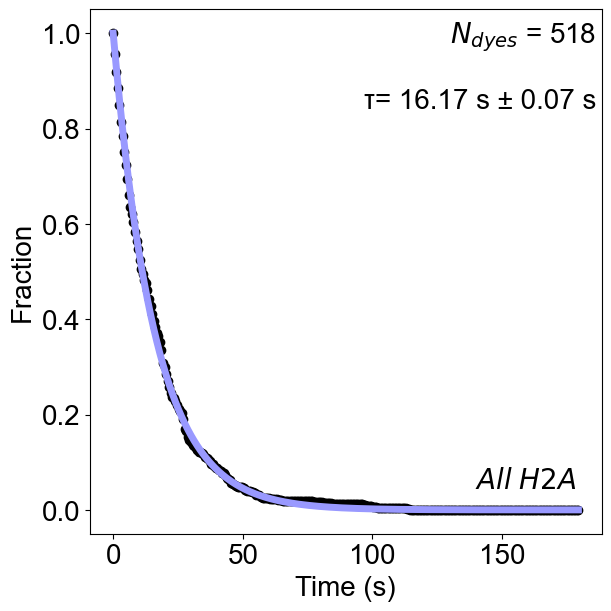

In [20]:
#################
# Lifetime plot #
#################

# Config style
font = {'family':'arial', 'size'   : 20}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

# Generate figure
fig = plt.figure(constrained_layout=True,figsize=(6, 6))

# Customize axis 
gs = GridSpec(1, 1, figure=fig, width_ratios=[1])
ax = fig.add_subplot(gs[:, 0])
ax.legend(title= ' $\it{All}$'+  ' $\it{ H2A}$' ,  loc='lower right', frameon=False)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Fraction")

# Read data to plot
with open(os.path.join(data_dir, "dataLT.yaml"), "r") as file:
       dataLT = yaml.safe_load(file)

# Plot lifetime
plot_lifetime(dataLT,  '#9999ff', ax)

plt.show()